<a href="https://colab.research.google.com/github/DYNAFEM/REGRESION-PESO-BOVINOS/blob/MODELOS_SVR_RF_XGBOOST-REGRESSOR/V0_SVR_RF_BOVINO_REGRESION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Importar Librerias Necesarias

In [ ]:
# import the necessary packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# TensorFlow y Keras
import tensorflow as tf

# Visualización
import matplotlib.pyplot as plt


In [ ]:
print(tf.__version__)           # Debe mostrar versión >= 2.x
print("TensorFlow cargado.")

2.19.0
TensorFlow cargado.


2. Cargar los datos del archivo .txt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar datos procesados
ruta_train = '/content/drive/My Drive/REGRESION_PESO/DATOS_TRAIN_TEST_STANDARD/train_dataset.csv'
ruta_test = '/content/drive/My Drive/REGRESION_PESO/DATOS_TRAIN_TEST_STANDARD/test_dataset.csv'

train_df = pd.read_csv(ruta_train)
test_df = pd.read_csv(ruta_test)

# Separar datos
X_train = train_df.drop(columns=['weight_in_kg'])
y_train = train_df['weight_in_kg']

X_test = test_df.drop(columns=['weight_in_kg'])
y_test = test_df['weight_in_kg']

In [ ]:
print(X_train.head())
print(X_train.shape)

   age_in_year     teeth  height_in_inch     price  sex_MALE_BULL  color_RED  \
0     1.643310  1.653526       -0.948784 -0.242195       0.121867   0.829001   
1    -0.551338 -0.547596        0.523196  0.014779       0.121867   0.829001   
2    -0.551338 -0.547596       -0.059463 -0.587513       0.121867   0.829001   
3    -0.551338 -0.547596       -1.102116 -0.270972       0.121867   0.829001   
4    -0.551338 -0.547596       -1.102116 -0.645066       0.121867   0.829001   

   breed_HOSTINE_CROSS  breed_LOCAL  breed_MIR_KADIM  breed_PABNA_BREED  \
0            -0.260208     0.677551        -0.070014          -0.099258   
1            -0.260208     0.677551        -0.070014          -0.099258   
2            -0.260208     0.677551        -0.070014          -0.099258   
3            -0.260208     0.677551        -0.070014          -0.099258   
4            -0.260208     0.677551        -0.070014          -0.099258   

   breed_RED_CHITTAGONG  breed_SAHIWAL  breed_SINDHI  size_LARGE  si

SEPARAR VARIABLE PREDICTORA

NORMALIZAR VARIABLES PREDICTORAS

5. Separar datos en entrenamiento y prueba.

# MODELO SUPPORT VECTOR REGRESSOR SVR

In [ ]:
from sklearn.svm import SVR

# Crear y ajustar el modelo
svr = SVR(kernel='rbf', C=100, epsilon=0.1, gamma=0.01)
# Now X_train_scaled and y_train_scaled should be defined
svr.fit(X_train, y_train.ravel()) # Use ravel() for y_train_scaled for SVR

/tmp/ipython-input-12429377.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  svr.fit(X_train, y_train.ravel()) # Use ravel() for y_train_scaled for SVR


SVR(C=100, gamma=0.01)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

# Definir rango de búsqueda
param_grid = {
    'C': [1, 10, 100],
    'epsilon': [0.01, 0.1, 0.5],
    'gamma': ['scale', 0.01, 0.1, 1]
}

# Crear el modelo base
svr_base = SVR(kernel='rbf')

# Búsqueda en grilla con validación cruzada
grid_search = GridSearchCV(svr_base, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros encontrados:")
print(grid_search.best_params_)

# Obtener el mejor modelo
best_svr = grid_search.best_estimator_


Mejores hiperparámetros encontrados:
{'C': 100, 'epsilon': 0.5, 'gamma': 0.01}


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predicciones en el test set
y_pred = best_svr.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nEvaluación del mejor modelo (en test set):")
print(f"MAE: {mae:.2f} kg")
print(f"MSE: {mse:.2f} kg²")
print(f"RMSE: {rmse:.2f} kg")
print(f"R² Score: {r2:.3f}")




Evaluación del mejor modelo (en test set):
MAE: 11.17 kg
MSE: 1227.59 kg²
RMSE: 35.04 kg
R² Score: 0.653


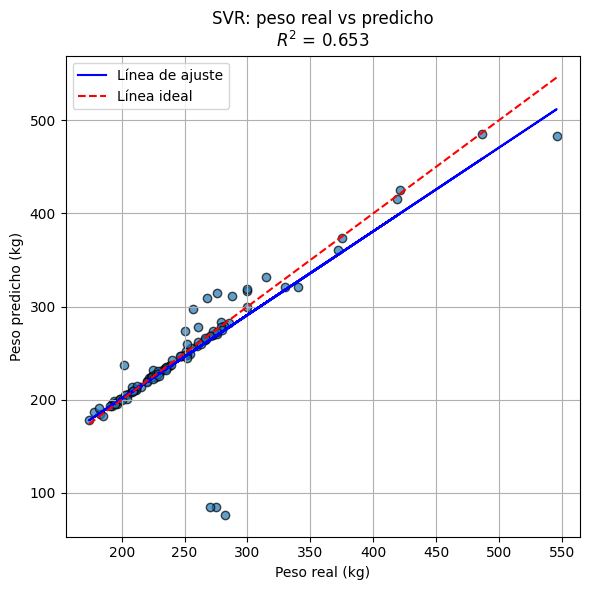

In [ ]:
import numpy as np
coef = np.polyfit(y_test, y_pred, 1)
poly1d_fn = np.poly1d(coef)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7, edgecolor='k')
plt.plot(y_test, poly1d_fn(y_test), color='blue', label='Línea de ajuste')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Línea ideal')
plt.xlabel("Peso real (kg)")
plt.ylabel("Peso predicho (kg)")
plt.title(f"SVR: peso real vs predicho\n$R^2$ = {r2:.3f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(best_svr, X_train, y_train, cv=5, scoring='r2')
print("R² por fold:", scores)
print("R² promedio:", scores.mean())



R² por fold: [0.6587846  0.81520104 0.65608426 0.47481232 0.85688495]
R² promedio: 0.6923534331565446


In [ ]:
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: R² = {score:.3f}")
print(f"\nR² promedio (validación cruzada): {scores.mean():.3f}")

Fold 1: R² = 0.659
Fold 2: R² = 0.815
Fold 3: R² = 0.656
Fold 4: R² = 0.475
Fold 5: R² = 0.857

R² promedio (validación cruzada): 0.692


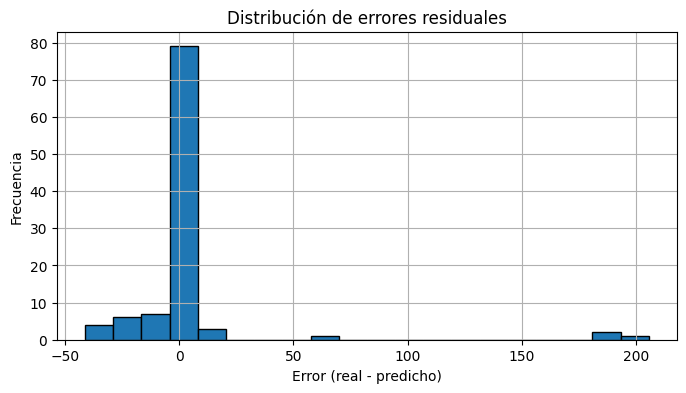

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8,4))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title("Distribución de errores residuales")
plt.xlabel("Error (real - predicho)")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Elegir 25 índices aleatorios del conjunto de prueba
np.random.seed(2024)
random_indices = np.random.choice(X_test.index, size=25, replace=False)

# Extraer muestras y valores reales
X_sample = X_test.loc[random_indices]
y_real = y_test.loc[random_indices]

# X ya está escalado, así que lo usamos directamente
y_pred = best_svr.predict(X_sample)

# Crear tabla de comparación
pred_df = pd.DataFrame({
    'Peso real (kg)': y_real.values,
    'Peso predicho (kg)': y_pred,
    'Error absoluto (kg)': np.abs(y_real.values - y_pred)
}, index=random_indices)

# Ordenar por error
pred_df = pred_df.sort_values(by='Error absoluto (kg)', ascending=False)

# Mostrar
print(pred_df.round(2))


    Peso real (kg)  Peso predicho (kg)  Error absoluto (kg)
10             546              483.11                62.89
24             300              317.23                17.23
90             252              260.25                 8.25
26             225              232.21                 7.21
16             279              283.46                 4.46
98             230              225.73                 4.27
15             252              248.40                 3.60
89             276              273.00                 3.00
5              285              282.42                 2.58
71             199              201.25                 2.25
86             225              222.79                 2.21
46             272              269.84                 2.16
51             203              204.80                 1.80
6              196              197.71                 1.71
35             192              193.61                 1.61
34             250              248.50  

In [ ]:
results = pd.DataFrame({
    'Real_Weight': y_real.values,           # y_real = subconjunto de y_test
    'Predicted_Weight': y_pred.ravel()
})
print(results.head())


   Real_Weight  Predicted_Weight
0          252        260.251834
1          261        262.342592
2          196        195.649718
3          226        224.961519
4          250        248.500771


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predecir directamente con los datos ya escalados
y_pred = best_svr.predict(X_test)

# Calcular métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Mostrar resultados
print(f"MAE : {mae:.2f} kg")
print(f"MSE : {mse:.2f} kg²")
print(f"RMSE: {rmse:.2f} kg")
print(f"R²  : {r2:.4f}")


MAE : 11.17 kg
MSE : 1227.59 kg²
RMSE: 35.04 kg
R²  : 0.6534


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.2f} kg²")
print(f"RMSE: {rmse:.2f} kg")
print(f"MAE: {mae:.2f} kg")


MSE: 1227.59 kg²
RMSE: 35.04 kg
MAE: 11.17 kg


# MODELO CON RANDOM FOREST REGRESSOR

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)


RandomForestRegressor(n_jobs=-1, random_state=42)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predecir
y_pred = rf_model.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.3f}")


MAE: 4.01
MSE: 76.90
RMSE: 8.77
R² Score: 0.978


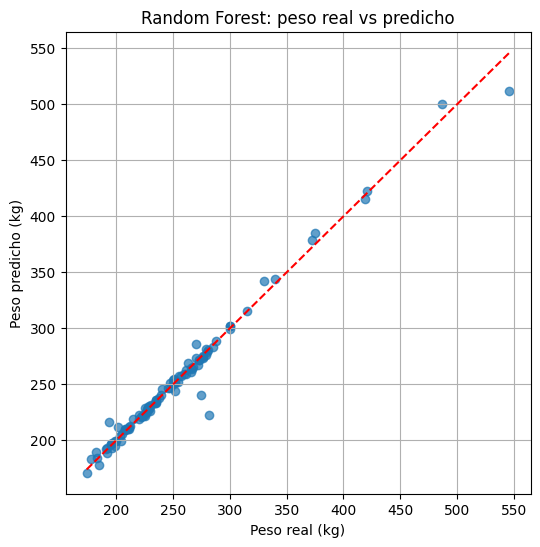

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Peso real (kg)")
plt.ylabel("Peso predicho (kg)")
plt.title("Random Forest: peso real vs predicho")
plt.grid(True)
plt.show()

In [ ]:
# Número de muestras aleatorias
N = 25

# Seleccionar N muestras aleatorias de X_test
np.random.seed(42)
random_indices = np.random.choice(X_test.index, size=N, replace=False)

X_sample = X_test.loc[random_indices]
y_real = y_test.loc[random_indices]

# Predicción con el modelo entrenado
y_pred = rf_model.predict(X_sample)

# Crear un DataFrame comparativo
pred_df = pd.DataFrame({
    'Peso real (kg)': y_real.values,
    'Peso predicho (kg)': y_pred,
    'Error (kg)': np.abs(y_real.values - y_pred)
}, index=random_indices)

# Mostrar resultados
print(pred_df.round(2))

     Peso real (kg)  Peso predicho (kg)  Error (kg)
30              251              255.05        4.05
67              270              273.48        3.48
62              268              265.25        2.75
47              273              271.29        1.71
42              220              219.41        0.59
40              223              221.64        1.36
90              252              252.38        0.38
45              247              251.13        4.13
10              546              511.93       34.07
0               300              299.58        0.42
18              247              246.96        0.04
31              231              231.69        0.69
97              246              247.06        1.06
85              204              199.05        4.95
76              227              227.74        0.74
4               276              274.94        1.06
79              210              210.21        0.21
33              215              218.67        3.67
12          